# Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os.path
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras import Model

from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Data Load

In [168]:
!unzip -q round_imgs.zip; rm round_imgs.zip

'unzip'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [2]:
image_dir = Path('./data/')

In [3]:
#initialized value  
width=200 #the width of OCT image 
height=200 #the height of OCT image 
number_of_batch=32 # the number of batch 

In [4]:
## new
filepaths = pd.Series(list(image_dir.glob(r'train/*/*.jpg')), name='Filepath').astype(str)
angles = pd.Series(filepaths.apply(lambda x : os.path.split(os.path.split(x)[0])[1]), name='value').astype(np.float)
train_images = pd.concat([filepaths, angles], axis = 1).sample(frac=1.0, random_state=1).reset_index(drop=True)

filepaths = pd.Series(list(image_dir.glob(r'test/*/*.jpg')), name='Filepath').astype(str)
angles = pd.Series(filepaths.apply(lambda x : os.path.split(os.path.split(x)[0])[1]), name='value').astype(np.float)
test_images = pd.concat([filepaths, angles], axis = 1).sample(frac=1.0, random_state=1).reset_index(drop=True)

C:\Users\DONGHU~1\AppData\Local\Temp/ipykernel_8948/1489184617.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  angles = pd.Series(filepaths.apply(lambda x : os.path.split(os.path.split(x)[0])[1]), name='value').astype(np.float)
C:\Users\DONGHU~1\AppData\Local\Temp/ipykernel_8948/1489184617.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecat

In [5]:
print(len(train_images))
train_images.head(5)

60


,Filepath,value
0,data\train\30\09.jpg,30.0
1,data\train\300\0879.jpg,300.0
2,data\train\0\01128.jpg,0.0
3,data\train\330\01006.jpg,330.0
4,data\train\60\0.jpg,60.0


In [6]:
print(len(test_images))
test_images.head(5)

60


,Filepath,value
0,data\test\30\09.jpg,30.0
1,data\test\300\0879.jpg,300.0
2,data\test\0\01128.jpg,0.0
3,data\test\330\01006.jpg,330.0
4,data\test\60\0.jpg,60.0


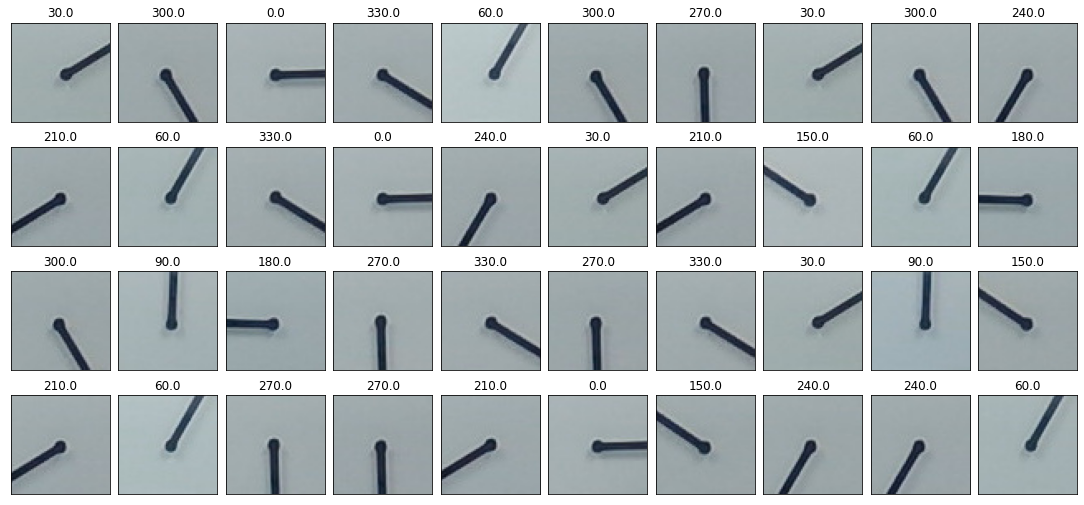

In [7]:
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(train_images.Filepath[i]))
    ax.set_title(train_images.value[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [8]:
train_df=train_images.copy()
test_df=test_images.copy()

In [9]:
print(train_df.shape)
print(test_df.shape)

(60, 2)
(60, 2)


In [10]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale =1./255
#     validation_split=0.2

)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale =1./255
)

In [11]:
train_generator = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='value',
    target_size=(height, width),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training',
    # save_to_dir= '..',
    # save_format = 'jpeg'
)
test_generator = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='value',
    target_size = (height, width),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle = False
)
# val_images = train_generator.flow_from_dataframe(
#     dataframe=train_df,
#     x_col='Filepath',
#     y_col='value',
#     target_size = (height, width),
#     color_mode='rgb',
#     class_mode='raw',
#     batch_size=32,
#     shuffle=True,
#     seed=42,
#     subset='validation'
# )

Found 60 validated image filenames.
Found 60 validated image filenames.


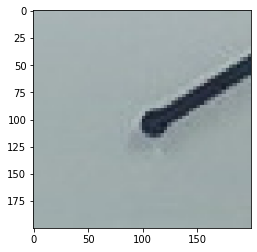

In [12]:
# 만들어진 trian generator 이미지 출력
x_train, y_train = train_generator.next()
for idx in range(1):  
    # print(x_train[idx]) # generator의 value 확인
    # print(y_train[idx])
    plt.imshow(x_train[idx]) 
    plt.show()

# Model

In [13]:
from tensorflow.keras.applications import ResNet50

In [14]:
resnet_model = ResNet50(weights=None, input_shape=(height, width, 3), include_top=False)
last = resnet_model.output
x = Flatten()(last)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
output_layer = Dense(1, activation='linear')(x)

resnet_model = Model(resnet_model.input, output_layer)
resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [15]:
model_path = 'resnet50.h5'

# Loss Function

In [81]:
def L1_loss(new_true_val, new_pred_val):
  pass

def min_loss(new_true_val, new_pred_val):
    new_thres_val = 1
    #error = new_true_val - new_pred_val
    new_true_val = float(new_true_val)
    new_true_val
    error1 = new_true_val - new_pred_val
    sub_num = tf.constant([12],dtype=float)
    error2 = sub_num - tf.abs(new_true_val - new_pred_val)
    if tf.less(error1, error2)[0]:
        error = error1
    else:
        error = error2
    small_err = tf.abs(error) <= new_thres_val
    new_err_loss = tf.abs(error)/2
    max_err_loss = new_thres_val * (tf.abs(error) - new_thres_val / 2)
    return tf.where(small_err, new_err_loss, max_err_loss)
# tf.where(bool_type, True일때 출력값, False일때 출력값)

def sin_loss(new_true_val, new_pred_val): # sin Loss⇒sin((x2-x1)/2), 
    pi_on_180 = 0.017453292519943295 # convert val to radian
    new_thres_val = 0.1
    error1 = tf.abs(new_true_val - new_pred_val) * pi_on_180
    error = tf.sin(error1/2)
    small_err = new_thres_val <= tf.abs(error)
    new_err_loss = tf.abs(error)
    max_err_loss = new_thres_val * tf.abs(error)
    return tf.where(small_err, new_err_loss, max_err_loss)
    
def cos_loss(new_true_val, new_pred_val): # cos Loss⇒|-cos((x2-x1)/2)+1|
    pi_on_180 = 0.017453292519943295 # convert val to radian
    new_thres_val = 0.1
    error1 = (new_true_val - new_pred_val) * pi_on_180
    error =  -tf.cos((error1/2)) + 1
    small_err = new_thres_val <= tf.abs(error)
    new_err_loss = tf.abs(error)
    max_err_loss = new_thres_val * tf.abs(error)
    return tf.where(small_err, new_err_loss, max_err_loss)

In [79]:
pi_on_180 = 0.017453292519943295 # convert val to radian
temp = tf.convert_to_tensor([0, 90.,180., 270., 360.])
print(temp*pi_on_180)
print(tf.cos(temp * pi_on_180)+1)


pi_on_180 = 0.017453292519943295 # convert val to radian
temp = tf.convert_to_tensor([0, 90.,180., 270., 360.])
print(temp*pi_on_180)
print(tf.sin(temp * pi_on_180))

tf.Tensor([0.        1.5707964 3.1415927 4.712389  6.2831855], shape=(5,), dtype=float32)


<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([2.        , 0.99999994, 0.        , 1.        , 2.        ],
      dtype=float32)>

# Train

In [82]:
resnet_model.compile(optimizer='Adam', loss=cos_loss) # loss='mse'
history = resnet_model.fit(
    train_generator, 
    epochs=3,
)

# history = res_model.fit(
#     train_images, 
#     validation_data=val_images, 
#     epochs=100,
#     callbacks=[
#           tf.keras.callbacks.EarlyStopping(
#               monitor='val_loss',
#               patience=5,
#               restore_best_weights=True
#         )
#     ]
# )

Epoch 1/3
2/2 [==============================] - 26s 12s/step - loss: 1.0411
Epoch 2/3
2/2 [==============================] - 21s 12s/step - loss: 0.9006
Epoch 3/3
2/2 [==============================] - 23s 12s/step - loss: 0.8278


In [ ]:
resnet_model.save(model_path)

# Result

In [112]:
prediction_value = np.squeeze(resnet_model.predict(test_generator))
true_value = test_generator.labels

rmse = np.sqrt(resnet_model.evaluate(test_generator, verbose=0))
print("Test RMSE : {:.5f}".format(rmse))

r2 = r2_score(true_value, prediction_value)
print("Test R^2 Score: {:.5f}".format(r2))

Test RMSE : 12.12843
Test R^2 Score: -2.31580


In [ ]:
# null_rmse = np.sqrt(np.sum((true_value - np.mean(true_value))**2) / len(true_value))
# print("Null/Baseline Model Test RMSE: {:.5f}".format(null_rmse))

In [146]:
import cv2
for i in range(10):
  temp = test_images.Filepath[i]
  print(temp, end="  ")
  img2 = cv2.imread(temp)
  # int -> float
  scalingFactor = 1/255.0
  # Convert unsigned int 8bit to float
  img2 = np.float32(img2)
  img2 = img2*scalingFactor
  print(img2.shape)
  # input layer 형식 맞추기
  img2 = cv2.resize(img2, (height, width))
  print(img2.shape)

  img2 = img2.reshape(-1, height, width,3)
  print(np.squeeze(resnet_model.predict(img2)))

data\test\30\0517.jpg  (60, 60, 3)
(200, 200, 3)
7.401151
data\test\300\0879.jpg  (60, 60, 3)
(200, 200, 3)
7.4048476
data\test\0\01125 - 복사본 (4).jpg  ()
(200, 200)


ValueError: cannot reshape array of size 40000 into shape (200,200,3)

In [119]:
img2.shape

(1, 200, 200, 1)

# Model Save

In [ ]:
res_model.save('my_model_17.h5')